## Import Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib
import re
from dateutil import parser

from nltk.corpus import stopwords
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import pandas as pd
from collections import Counter
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
import emoji

## Import Datasets

In [2]:
df = pd.read_csv('raw_data.csv')
df.head()

,review,date,stars,name,source,state,title
0,Lately it's very common to wait over 2 hours f...,"January 20, 2024",Rated 1 stars out of five stars,Bastian H,Google Play Store,NaN,NaN
1,Love it. Great offers. Good selections. Food a...,"January 20, 2024",Rated 5 stars out of five stars,Andrew Higgs,Google Play Store,NaN,NaN
2,Very disappointed in this app. I've used it fo...,"January 19, 2024",Rated 1 stars out of five stars,Kristi B,Google Play Store,NaN,NaN
3,Fairly easy to use but trying to find out what...,"January 20, 2024",Rated 2 stars out of five stars,broomee c,Google Play Store,NaN,NaN
4,Don't like the fact u can't get a refund unles...,"January 19, 2024",Rated 4 stars out of five stars,Teresa Anderson,Google Play Store,NaN,NaN


## EDA and Data Cleaning

In [3]:
df.shape    

(8955, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8955 entries, 0 to 8954
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  8955 non-null   object
 1   date    8955 non-null   object
 2   stars   8955 non-null   object
 3   name    8943 non-null   object
 4   source  8955 non-null   object
 5   state   130 non-null    object
 6   title   202 non-null    object
dtypes: object(7)
memory usage: 489.9+ KB


In [5]:
df = df.drop(['state', 'title', 'name'], axis=1)

In [6]:
df.nunique()

review    8869
date      1141
stars       15
source       5
dtype: int64

### Removing Other Languages

In [7]:
from langdetect import detect
from collections import Counter

def detect_language(text):
    try:
        return detect(text)
    except:
        return None

# detect language for each text in 'review'
df["language"] = df["review"].apply(lambda x: detect_language(x))

# get counts of each language
lang_counts = Counter(df["language"].values)

print(lang_counts)

Counter({'en': 8897, 'fr': 12, 'da': 12, 'es': 6, 'de': 4, 'af': 3, None: 3, 'no': 3, 'id': 2, 'so': 2, 'it': 2, 'nl': 1, 'ca': 1, 'ro': 1, 'hu': 1, 'cy': 1, 'hr': 1, 'sv': 1, 'pt': 1, 'tr': 1})


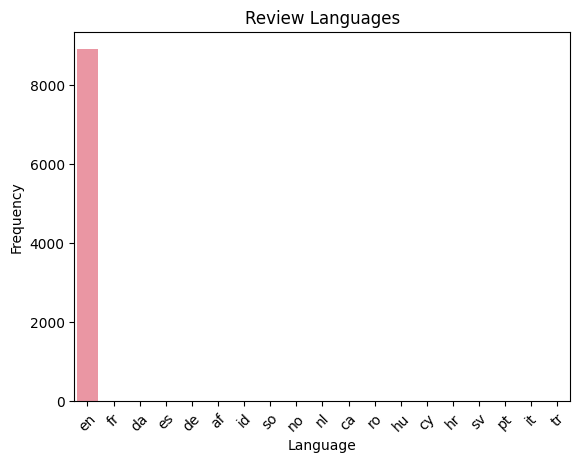

In [8]:
lang_df = pd.DataFrame.from_dict(lang_counts, orient='index', columns=['count']) 

sns.barplot(x=lang_df.index, y=lang_df['count'])

plt.xticks(rotation=45) 
plt.xlabel('Language')
plt.ylabel('Frequency')
plt.title('Review Languages')

plt.show()

In [9]:
# Keep only English reviews
df = df[df['language'] == 'en']
# Re-count languages
lang_counts = Counter(df['language'].values) 
print(lang_counts)

Counter({'en': 8897})


In the analysis, I filtered the dataset to include only rows where the detected language is English. This targeted approach allows a focused examination of reviews specifically written in English. By doing so, we aim to gain insights into customer experiences with Uber Eats, considering the perspectives of English-speaking users. This refined dataset provides a more nuanced understanding of the platform's performance within the English-speaking user segment.

In [10]:
df = df.drop(['language'], axis=1)

### Cleaning Stars

In [11]:
df['stars'].unique()

array(['Rated 1 stars out of five stars',
       'Rated 5 stars out of five stars',
       'Rated 2 stars out of five stars',
       'Rated 4 stars out of five stars',
       'Rated 3 stars out of five stars', '1', '5', '4', '3', '2',
       'Rated 3 out of 5 stars', 'Rated 5 out of 5 stars',
       'Rated 2 out of 5 stars', 'Rated 1 out of 5 stars',
       'Rated 4 out of 5 stars'], dtype=object)

In [12]:
def clean_rating(rating):
    match = re.search(r'\d+', rating)
    if match:
        return match.group()
    return rating   

In [13]:
df['stars'] = df['stars'].apply(clean_rating)

In [14]:
df.head()

,review,date,stars,source
0,Lately it's very common to wait over 2 hours f...,"January 20, 2024",1,Google Play Store
1,Love it. Great offers. Good selections. Food a...,"January 20, 2024",5,Google Play Store
2,Very disappointed in this app. I've used it fo...,"January 19, 2024",1,Google Play Store
3,Fairly easy to use but trying to find out what...,"January 20, 2024",2,Google Play Store
4,Don't like the fact u can't get a refund unles...,"January 19, 2024",4,Google Play Store


### Cleaning Dates Values and EDA

In [15]:
df['date'].unique()

array(['January 20, 2024', 'January 19, 2024', 'January 12, 2024', ...,
       'Date of experience: July 28, 2023',
       'Date of experience: July 26, 2023',
       'Date of experience: July 27, 2023'], dtype=object)

In [16]:
def parse_and_format_date(date_str):
    try:
        # Remove any prefixes like "Date of experience:"
        date_str = date_str.replace("Date of experience: ", "")
        # Parse the date using dateutil.parser
        parsed_date = parser.parse(date_str)
        # Format the date as YYYY-MM-DD
        formatted_date = parsed_date.strftime('%Y-%m-%d')
        return formatted_date
    except Exception as e:
        print(f"Error parsing date: {date_str}, Error: {e}")
        return None


In [17]:
# Assuming your DataFrame is named 'df'
df['date_formatted'] = df['date'].apply(parse_and_format_date)

In [18]:
df['date_formatted'].unique()

array(['2024-01-20', '2024-01-19', '2024-01-12', '2024-01-09',
       '2024-01-14', '2024-01-15', '2024-01-13', '2024-01-21',
       '2023-12-28', '2023-12-12', '2023-12-18', '2023-12-07',
       '2023-11-29', '2023-11-09', '2023-12-13', '2023-11-26',
       '2024-01-08', '2023-11-19', '2023-12-27', '2024-01-06',
       '2023-11-28', '2024-01-17', '2023-11-22', '2023-11-17',
       '2023-11-16', '2024-01-16', '2023-12-11', '2024-01-02',
       '2024-01-07', '2023-12-23', '2023-12-10', '2023-11-24',
       '2023-12-03', '2023-12-31', '2023-12-22', '2023-12-24',
       '2023-11-20', '2023-12-09', '2024-01-01', '2023-11-14',
       '2023-11-04', '2023-11-23', '2023-12-14', '2023-12-30',
       '2023-12-17', '2023-12-05', '2023-11-07', '2023-12-29',
       '2024-01-10', '2023-11-13', '2023-12-25', '2023-11-15',
       '2023-12-15', '2023-12-01', '2023-12-26', '2023-11-25',
       '2023-12-21', '2023-12-02', '2023-11-03', '2023-12-16',
       '2023-12-19', '2024-01-03', '2023-11-12', '2024-

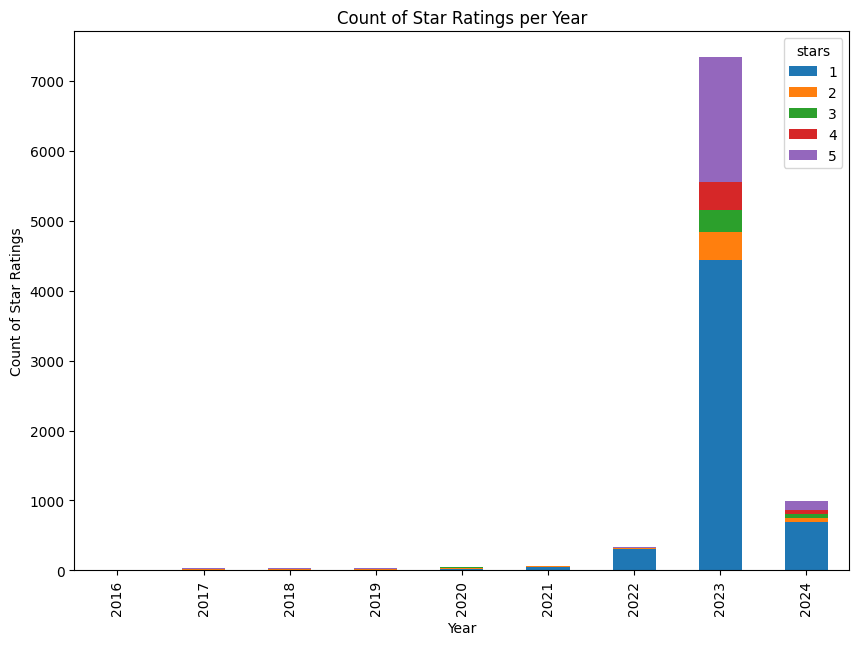

In [19]:
import matplotlib.pyplot as plt

# Ensure 'stars' is integer type
df['stars'] = df['stars'].astype(int)

# Extract year from 'date_formatted' if it's not already a column
df['year'] = pd.DatetimeIndex(df['date_formatted']).year

# Get count of each star rating for each year
star_counts = df.groupby(['year', 'stars']).size().unstack()

# Plot stacked bar chart
star_counts.plot(kind='bar', stacked=True, figsize=(10,7))

plt.title('Count of Star Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Count of Star Ratings')
plt.show()

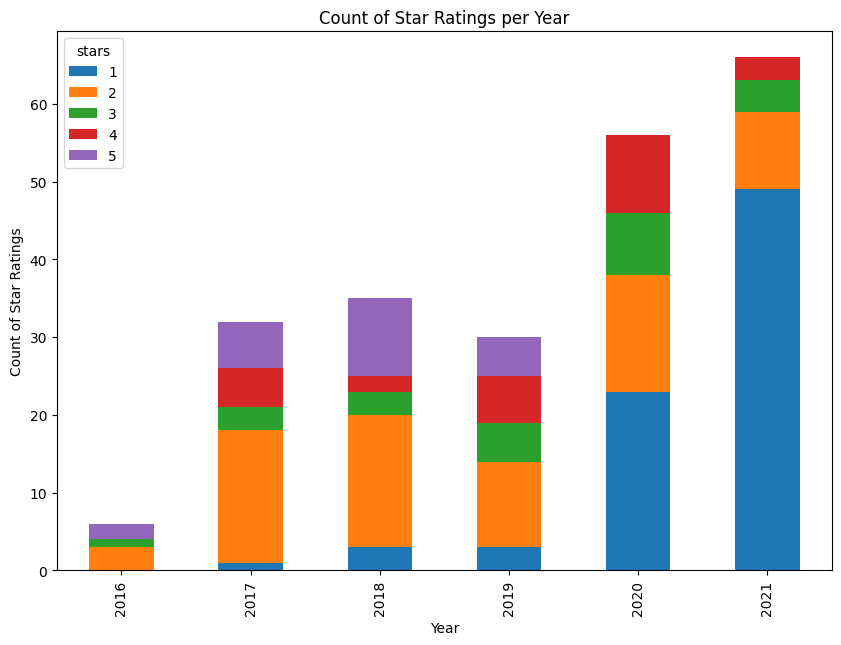

In [20]:
# Filter out 2023 and 2024
temp_df = df[~df['year'].isin([2022,2023, 2024])]

# Get count of each star rating for each year
star_counts = temp_df.groupby(['year', 'stars']).size().unstack()

# Plot stacked bar chart
star_counts.plot(kind='bar', stacked=True, figsize=(10,7))
plt.title('Count of Star Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Count of Star Ratings')
plt.show()

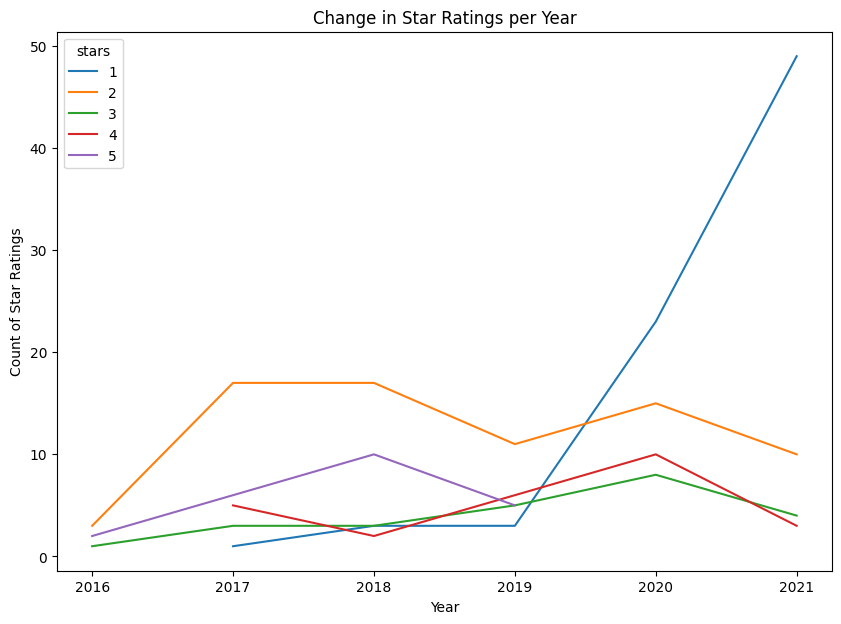

In [21]:
# Filter out 2022, 2023, and 2024
temp_df = df[~df['year'].isin([2022, 2023, 2024])]

# Get count of each star rating for each year
star_counts = temp_df.groupby(['year', 'stars']).size().unstack()

# Plot line graph
star_counts.plot(kind='line', figsize=(10,7))

plt.title('Change in Star Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Count of Star Ratings')
plt.show()

### Based on the Chart Above
The graph indicates a subtle rise in 1-star ratings for Uber Eats between 2014 and 2016. Establishing a direct connection to COVID-19 poses a challenge given the limited dataset. A comprehensive analysis incorporating data beyond 2016 becomes imperative to yield more definitive insights.

In the absence of additional data, confirming a causal relationship between COVID-19 and the surge in 1-star reviews on Uber Eats remains inconclusive. Nevertheless, it is plausible that the pandemic could have contributed to an uptick in negative reviews. Factors like prolonged wait times or suboptimal food temperatures during the pandemic might have increased customer dissatisfaction. Furthermore, the influx of new users during COVID-19 might have influenced lower ratings, particularly from those experiencing the service for the first time, potentially impacting overall rating trends.

### Cross-Index from Forbes
In response to COVID-19, Uber Eats witnessed a 10% sales surge amid widespread quarantines, according to a Forbes article by Marco Chiappetta on March 25, 2020. The increased demand resulted in a 30% rise in new customers and a surge in drivers seeking income supplementation. Major restaurants, including chains like Chipotle and Yum Brands, turned to Uber Eats to connect with customers as traditional ride-sharing declined. Although a positive amidst pandemic challenges, the article suggested that the heightened activity might not fully offset Uber's ride-share decline and could potentially increase losses for Uber Eats, given reported financial dynamics.

Source: [Forbes](https://www.forbes.com/sites/marcochiappetta/2020/03/25/uber-eats-demand-soars-due-to-covid-19-crisis/?sh=867ac11580ca)

## Data Pre-processing

In [26]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Removing Numbers
    tokens = [word for word in tokens if not word.isdigit()]

    # Removing Special Characters and Punctuation
    tokens = [word for word in tokens if word.isalpha()]

    # Removing Stop Words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # # Removing Emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642" 
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    tokens = [word for word in tokens if not emoji_pattern.match(word)]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

In [27]:
df['cleaned_text'] = df['review'].apply(preprocess_text)

# Counting the most common words
word_counts = Counter()

for _, row in df.iterrows():
    word_counts.update(row['cleaned_text'])

print(word_counts.most_common(10))

[('order', 8699), ('uber', 6006), ('food', 5397), ('service', 4566), ('driver', 3815), ('delivery', 3619), ('time', 3512), ('app', 3320), ('eats', 3198), ('customer', 3086)]


In [28]:
# Define stop words
stop_words = set(stopwords.words('english'))
custom_stop_words = ['uber', 'eats', 'order', 'ordered']
stop_words.update(custom_stop_words)

# Remove stop words
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: [word for word in x if word not in stop_words])

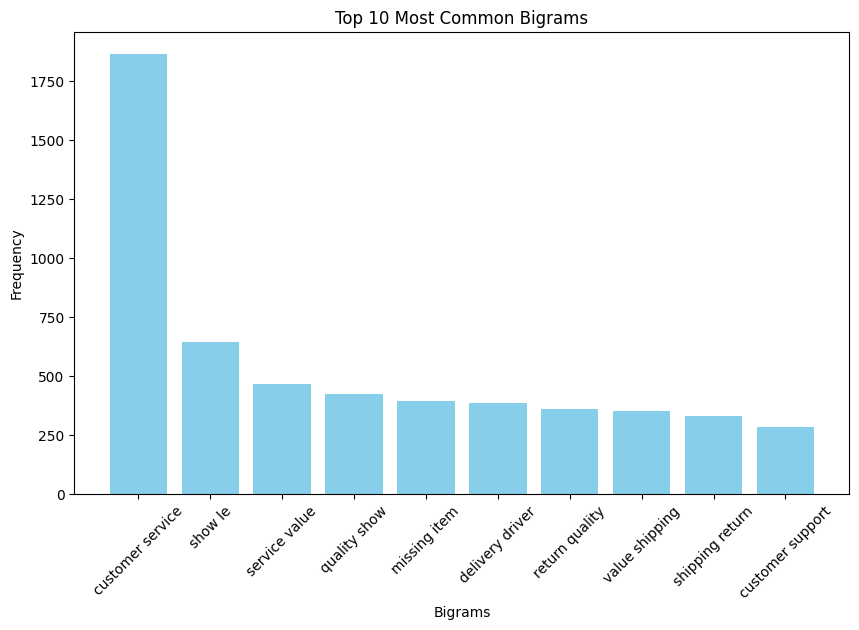

In [29]:
from nltk import ngrams

# Create a list of all words
all_words = [word for sublist in df['cleaned_text'] for word in sublist]

# Generate bigrams
bigrams = ngrams(all_words, 2)

# Count bigrams
bigram_counts = Counter(bigrams)

# Plotting the top 10 most common bigrams
common_bigrams = dict(bigram_counts.most_common(10))

plt.figure(figsize=(10, 6))
plt.bar([' '.join(k) for k in common_bigrams.keys()], common_bigrams.values(), color='skyblue')
plt.title('Top 10 Most Common Bigrams')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

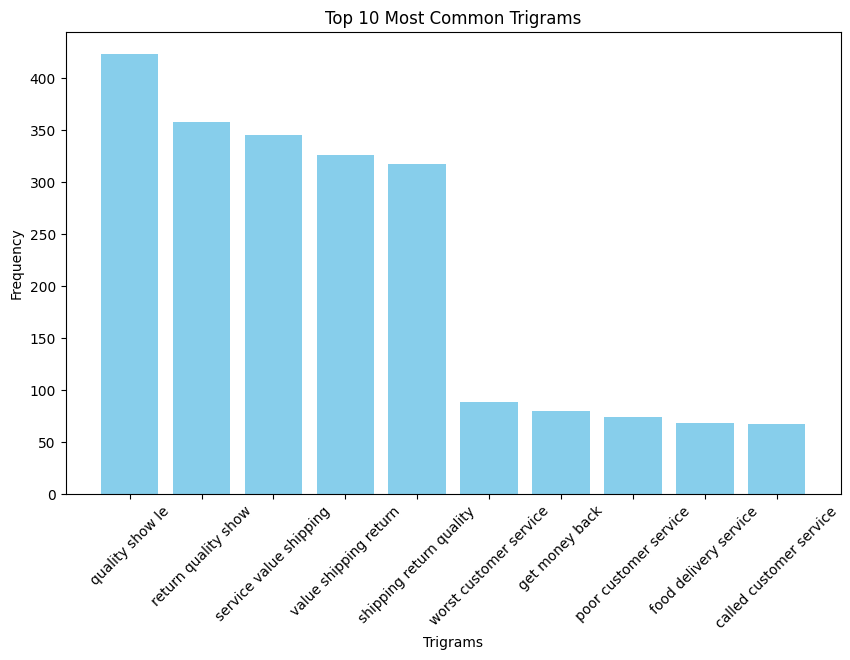

In [30]:
# Create a list of all words
all_words = [word for sublist in df['cleaned_text'] for word in sublist]

# Generate trigrams
trigrams = ngrams(all_words, 3)

# Count trigrams
trigram_counts = Counter(trigrams)

# Plotting the top 10 most common trigrams
common_trigrams = dict(trigram_counts.most_common(10))

plt.figure(figsize=(10, 6))
plt.bar([' '.join(k) for k in common_trigrams.keys()], common_trigrams.values(), color='skyblue')
plt.title('Top 10 Most Common Trigrams')
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## Insight
The charts reveal prevalent trigrams, signaling concerns with Uber Eats' customer service and an overarching negative sentiment in reviews. Specifically, an analysis of the "get money back" trigram unveils challenges faced by customers in securing refunds through the app, underscoring a substantial issue within the platform's customer support.

The frequent appearance of the "get money back" trigram consistently points to dissatisfaction among users with the refund process. This suggests that Uber Eats customers encountered obstacles when seeking reimbursement for problematic orders, ultimately fostering a negative perception of the platform's customer service.

### Cross-Reference
The article "Uber Eats Has a Customer-Service Problem" by Daniel Kline discusses the platform's struggle with customer service, emphasizing issues in problem resolution and refunds. Uber Eats reportedly offers refunds without effectively addressing the underlying delivery problems. The customer service process involves scripted responses that lack practical solutions, resulting in a poor rating of 1.5 out of 5 based on 18,000 reviews. The article contextualizes Uber Eats within broader industry challenges, attributing declining customer satisfaction to a shift away from prioritizing customer happiness. 

Source: [TheStreet](https://www.thestreet.com/investing/uber-eats-customer-service-problem)

In [31]:
df.head()

,review,date,stars,source,date_formatted,year,cleaned_text
0,Lately it's very common to wait over 2 hours f...,"January 20, 2024",1,Google Play Store,2024-01-20,2024,"[lately, common, wait, hour, food, passed, dri..."
1,Love it. Great offers. Good selections. Food a...,"January 20, 2024",5,Google Play Store,2024-01-20,2024,"[love, great, offer, good, selection, food, sh..."
2,Very disappointed in this app. I've used it fo...,"January 19, 2024",1,Google Play Store,2024-01-19,2024,"[disappointed, app, used, long, time, service,..."
3,Fairly easy to use but trying to find out what...,"January 20, 2024",2,Google Play Store,2024-01-20,2024,"[fairly, easy, use, trying, find, happening, c..."
4,Don't like the fact u can't get a refund unles...,"January 19, 2024",4,Google Play Store,2024-01-19,2024,"[like, fact, u, ca, get, refund, unless, u, ta..."


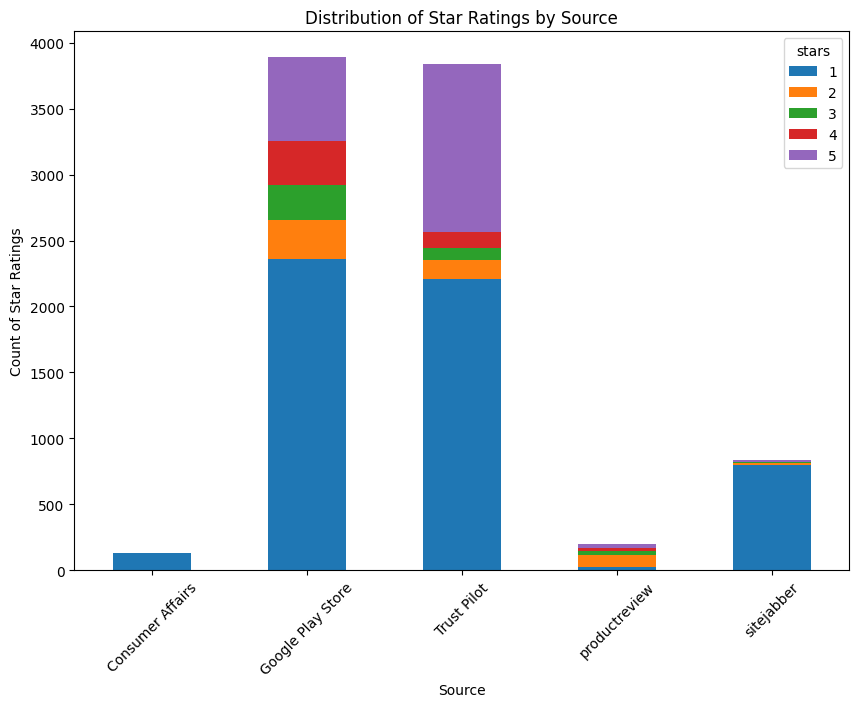

In [33]:
# Group by 'source' and 'stars' and count the number of rows
star_distribution = df.groupby(['source', 'stars']).size().unstack()

# Plot bar chart
star_distribution.plot(kind='bar', stacked=True, figsize=(10,7))

plt.title('Distribution of Star Ratings by Source')
plt.xlabel('Source')
plt.ylabel('Count of Star Ratings')
plt.xticks(rotation=45)
plt.show()

The graph highlights an interesting difference between the sentiment distribution of reviews on Google Play Store versus Trustpilot. Specifically, the Trustpilot reviews appear more positively skewed, with most labeled as 5 stars. In contrast, the Google Play store has a more even distribution of positive and negative sentiment ratings. This imbalance in the training data could bias any machine learning models we build. With significantly more positive reviews, algorithms may be prone to predicting the majority positive class. To mitigate this, we likely need to consider resampling the Trustpilot data to balance the sentiment distribution. 

Techniques like undersampling majority positive samples or oversampling minority negative samples could help even out the class imbalance prior to training. This would expose the model to a more representative ratio of positive to negative sentiment during training. Appropriate preprocessing through sentiment-based resampling of the Trustpilot data can improve model robustness and performance on minority classes. In summary, the imbalanced sentiment distribution highlights the need for smart data sampling strategies before applying machine learning algorithms. Even if review ratings are skewed, we want our model to learn from a balanced set of positive and negative sentiment samples. The method will be used during modelling but its important to be noted here.

```py 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Define oversampling strategy
over = RandomOverSampler(sampling_strategy='auto')

# Fit and apply the transform
X_over, y_over = over.fit_resample(df.drop('sentiment', axis=1), df['sentiment'])

# Define undersampling strategy
under = RandomUnderSampler(sampling_strategy='auto')

# Fit and apply the transform
X_under, y_under = under.fit_resample(df.drop('sentiment', axis=1), df['sentiment'])
```

In [44]:
def assign_sentiment(stars):
    if stars in [1, 2]:
        return 'negative'
    elif stars == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['stars'].apply(assign_sentiment)

In [45]:
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sentiment
negative    6067
positive    2440
neutral      390
Name: count, dtype: int64


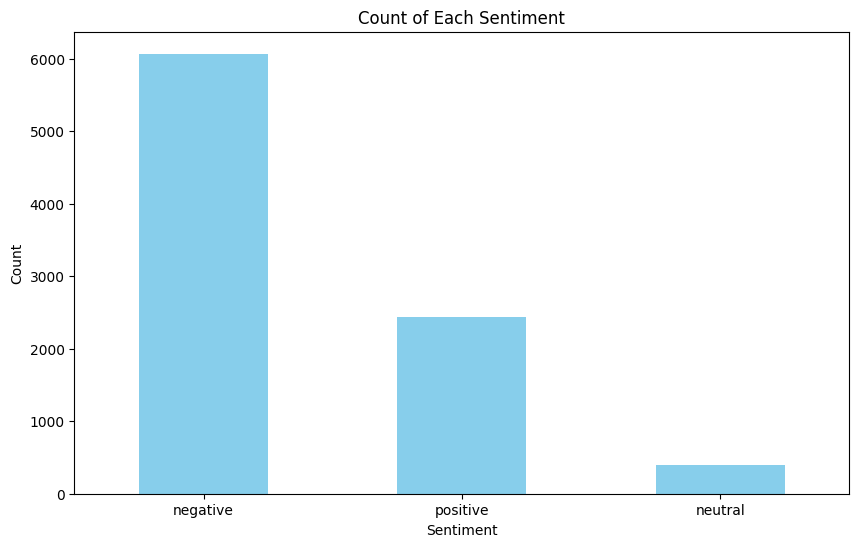

In [40]:
sentiment_counts = df['sentiment'].value_counts()

# Plot bar chart
sentiment_counts.plot(kind='bar', color='skyblue', figsize=(10,6))

plt.title('Count of Each Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [47]:
df_cleaned = df.drop(['review', 'date', 'date_formatted', 'year', 'source'], axis=1)

In [55]:
print(df_cleaned['cleaned_text'][30])

['delivery', 'great', 'major', 'issue', 'area', 'lately', 'however', 'received', 'notice', 'credit', 'late', 'delivery', 'removed', 'one', 'understand', 'could', 'go', 'pick', 'paying', 'service', 'time', 'compensation', 'late', 'another', 'side', 'effect', 'inflation']


In [56]:
df_cleaned.head()

,stars,cleaned_text,sentiment
0,1,"[lately, common, wait, hour, food, passed, dri...",negative
1,5,"[love, great, offer, good, selection, food, sh...",positive
2,1,"[disappointed, app, used, long, time, service,...",negative
3,2,"[fairly, easy, use, trying, find, happening, c...",negative
4,4,"[like, fact, u, ca, get, refund, unless, u, ta...",positive


In [57]:
df_cleaned.to_csv("cleaned_data.csv", index=False)

The above is an example of a typical review and in the subsequent stages of processing, after obtaining the TF-IDF vectors from the given review, the focus shifts to leveraging these representations for deeper analysis. Following TF-IDF and vectorization, the next steps include model creation for clustering and sentiment analysis.

```py
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the reviews to obtain TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)

```